In [ ]:
%load_ext tensorboard

In [1]:
import glob
import pandas as pd
import numpy as np
import torch

In [2]:
torch.cuda.is_available()

True

In [10]:
allFiles = glob.glob("dp/notebooks/lexicons/*")
allFiles.sort()
allDF = []

for f in allFiles:
    filename = f.split("/")[3][:-4]
    df = pd.read_csv(f, dtype=str, engine='python',
        encoding='utf-8', sep='\t',
        names=['grapheme', 'phoneme'])
    df.insert(2, 'filename', filename)
    allDF.append(df)

df = pd.concat(allDF, ignore_index=True)
df.insert(0, 'lang', 'pt_br')
df['phoneme'] = df['phoneme'].str.strip()

In [11]:
df['grapheme'] = df['grapheme'].map(str)
df['phoneme'] = df['phoneme'].map(str)

df['phoneme'] = df['phoneme'].str.replace("\\\\pau\\\\", '\\\\,\\\\')
df['phoneme'] = df['phoneme'].str.replace("a~", "ã")
df['phoneme'] = df['phoneme'].str.replace("e~", "ẽ")
df['phoneme'] = df['phoneme'].str.replace("i~", "ĩ")
df['phoneme'] = df['phoneme'].str.replace("o~", "õ")
df['phoneme'] = df['phoneme'].str.replace("u~", "ũ")
df['phoneme'] = df['phoneme'].str.replace("w~", "w̃")
df['phoneme'] = df['phoneme'].str.replace("j~", "j̃")

In [12]:
graphemes = ''.join(sorted(list(set(df['grapheme'].sum()))))

phonemes = pd.DataFrame(
    df['phoneme'].str.split("\\")
        .explode().drop_duplicates()
        .sort_values().reset_index(drop=True)
        .values.tolist(), columns=['phon']
)

phonemes['len'] = phonemes['phon'].str.len()
phonemes['upper'] = phonemes['phon'].str.isupper()
phonemes = phonemes.sort_values(by=['len', 'upper', 'phon'], ascending=False)['phon'].values.tolist()

phonemes.append("~")
phonemes.remove(" '")
phonemes.remove("")

df['phoneme'] = df['phoneme'].str.replace('\\', '')

In [13]:
hist = df.copy()
hist.phoneme = hist.phoneme.str.len()
hist.grapheme = hist.grapheme.str.len()

<AxesSubplot:>

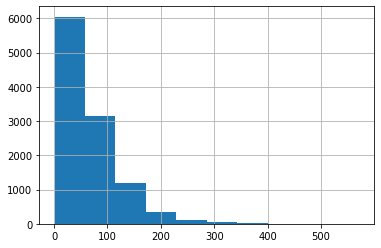

In [14]:
hist['grapheme'].hist()

<AxesSubplot:>

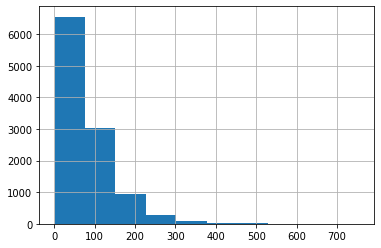

In [15]:
hist['phoneme'].hist()

In [16]:
print(hist['grapheme'].max(), hist['phoneme'].max())

571 754


In [17]:
hist['phoneme'].idxmax()

517

In [25]:
print(df.iloc[517]['grapheme'])

Pelo tratado de Fontainebleau, assinado pelos dois aliados em 27 de outubro de 1807, Portugal seria retalhado em três partes: a região norte, composta pelas províncias de Entre-Douro e Minho e batizada, pelo tratado, de Lusitânia Setentrional, caberia à rainha regente da Etrúria, Maria Luiza de Bourbon, da dinastia espanhola; Alentejo e Algarve, na região sul, passariam para D. Manoel de Godoy, o mais poderoso ministro espanhol, também chamado de príncipe da Paz; à França caberia a parte central e mais rica do país, composta por Beira, Trás os Montes e Estremadura.


In [7]:
df['gsize'] = df['grapheme'].apply(lambda x : len(x))
df['psize'] = df['phoneme'].apply(lambda x : len(x))
df = df[df['psize'] <= 100]
phonemes.sort(key=len, reverse=True)

In [87]:
df['gWords'] = df['grapheme'].str.count(' ') + 1
df['pWords'] = df['phoneme'].str.count(' ') + 1
df['grapheme'] = df['grapheme'].str.split(' ')
df['phoneme'] = df['phoneme'].str.split(' ')

In [88]:
df = (df.groupby('filename', as_index=False)
    .apply(lambda x: x.reset_index(drop=True)).reset_index().drop('level_0', axis=1))
df.level_1 = df.level_1 + 1

In [89]:
df[df.gWords > df.pWords].apply(lambda x:
    x.phoneme.extend([''] * (x.gWords - x.pWords)), axis=1)
df[df.pWords > df.gWords].apply(lambda x:
    x.grapheme.extend([''] * (x.pWords - x.gWords)), axis=1)
dfWords = (df.apply(pd.Series.explode)
    .drop(['lang', 'gWords', 'pWords'], axis=1))

In [6]:
allFilesFixed = glob.glob("dp/notebooks/lexicons_fixed/*")
allFilesFixed.sort()
allDFFixed = []

for f in allFilesFixed:
    filename = f.split("/")[3][:-4]
    dfFixed = pd.read_csv(f, dtype=str,
        encoding='utf-8', sep='\\t',
        names=['grapheme', 'phoneme'])
    dfFixed.insert(2, 'filename', filename)
    allDFFixed.append(dfFixed)

dfFixed = pd.concat(allDFFixed, ignore_index=True)
dfFixed.insert(0, 'lang', 'pt_br')

ValueError: No objects to concatenate

In [91]:
dfFixed['gWords'] = dfFixed['grapheme'].str.count(' ') + 1
dfFixed['pWords'] = dfFixed['phoneme'].str.count(' ') + 1
dfFixed['grapheme'] = dfFixed['grapheme'].str.split(' ')
dfFixed['phoneme'] = dfFixed['phoneme'].str.split(' ')

In [92]:
dfFixed = (dfFixed.groupby('filename', as_index=False)
    .apply(lambda x: x.reset_index(drop=True)).reset_index().drop('level_0', axis=1))
dfFixed.level_1 = dfFixed.level_1 + 1

In [93]:
dfFixed[dfFixed.gWords > dfFixed.pWords].apply(lambda x:
    x.phoneme.extend([''] * (x.gWords - x.pWords)), axis=1)
dfFixed[dfFixed.pWords > dfFixed.gWords].apply(lambda x:
    x.grapheme.extend([''] * (x.pWords - x.gWords)), axis=1)
dfFixedWords = (dfFixed.apply(pd.Series.explode)
    .drop(['lang', 'gWords', 'pWords'], axis=1))

In [94]:
phonemes = dfWords['phoneme']
phonemesFixed = dfFixedWords['phoneme']

In [96]:
phon = dfWords[phonemesFixed != phonemes][['filename', 'level_1', 'grapheme', 'phoneme']].to_csv('phon.txt', index=False)
phonFixed = dfFixedWords[phonemes != phonemesFixed][['filename', 'level_1', 'grapheme', 'phoneme']].to_csv('phonFixed.txt', index=False)

In [97]:
phon.to_csv('phon.txt', index=False)
phonFixed.to_csv('phonFixed.txt', index=False)

In [3]:
def levenshtein(target, predicted):
    d = np.zeros((len(target) + 1) * (len(predicted) + 1), dtype=np.uint8)
    d = d.reshape((len(target) + 1, len(predicted) + 1))
    for i in range(len(target) + 1):
        for j in range(len(predicted) + 1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i

    for i in range(1, len(target) + 1):
        for j in range(1, len(predicted) + 1):
            if target[i - 1] == predicted[j - 1]:
                d[i][j] = d[i - 1][j - 1]
            else:
                substitution = d[i - 1][j - 1] + 1
                insertion = d[i][j - 1] + 1
                deletion = d[i - 1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)

    return d[len(target)][len(predicted)], len(target)
